In [1]:
import numpy as np
import pandas as pd

In [49]:
import geopandas as gpd

In [2]:
import os

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import sys
sys.path.insert(1, '../tools')
from data_tools import *

In [50]:
import re

# Shapefile

In [204]:
bay_area_map = gpd.read_file('../data/bay_area_counties.geojson')

In [305]:
min_df = bay_area_map.geometry.bounds[['minx','miny']]
max_df = bay_area_map.geometry.bounds[['maxx','maxy']]

In [309]:
max_val = max_df.values.max(axis=0)
min_val = min_df.values.min(axis=0)

In [324]:
# bay area boundary
long_range = np.row_stack([min_val,max_val])[:,0]
lat_range = np.row_stack([min_val,max_val])[:,1]

# Business Info DataFrame

In [338]:
business_info = pd.read_csv('../data/all_businesses_info.csv')

In [339]:
sub_con = (business_info.longitude.between(long_range[0],long_range[1])) & \
            (business_info.latitude.between(lat_range[0],lat_range[1]))
# drop businesses outside of Bay Area
business_info = business_info[sub_con]

In [340]:
def fixed_capitalize(in_str):
    return ' '.join([i.capitalize() for i in in_str.strip().split(' ')])

In [341]:
# fix city name format
business_info['city'] = [fixed_capitalize(i) for i in business_info['city']]

In [342]:
geo_xy = gpd.points_from_xy(business_info.longitude, business_info.latitude)
geo_business_info = gpd.GeoDataFrame(business_info, geometry=geo_xy, crs=crs)

In [344]:
geo_business_info.head()

,id,alias,name,image_url,is_closed,url,review_count,rating,price,phone,...,transactions3,address1,address2,address3,city,zip_code,country,state,display_address,geometry
0,ucXuxH-JOwyL_hi0uzXjVw,lovina-calistoga,Lovina,https://s3-media1.fl.yelpcdn.com/bphoto/fiMg4W...,False,https://www.yelp.com/biz/lovina-calistoga?adju...,327,4.0,$$,1.707943e+10,...,NaN,1107 Cedar St,NaN,NaN,Calistoga,94515.0,US,CA,"1107 Cedar St, Calistoga, CA 94515",POINT (-122.57964 38.57659)
1,U69SHL0P_DGbjaB8TNIwLg,sams-social-club-calistoga-2,Sam's Social Club,https://s3-media1.fl.yelpcdn.com/bphoto/uzjx9K...,False,https://www.yelp.com/biz/sams-social-club-cali...,640,4.0,$$,1.707942e+10,...,NaN,1712 Lincoln Ave,NaN,NaN,Calistoga,94515.0,US,CA,"1712 Lincoln Ave, Calistoga, CA 94515",POINT (-122.57525 38.58221)
2,XITkuNFTKXeDKotFD9dPxA,solbar-calistoga,SolBar,https://s3-media1.fl.yelpcdn.com/bphoto/_5YbbL...,False,https://www.yelp.com/biz/solbar-calistoga?adju...,1047,4.0,$$$,1.707226e+10,...,NaN,755 Silverado Trl,NaN,Solage Hotel,Calistoga,94515.0,US,CA,"755 Silverado Trl, Solage Hotel, Calistoga, CA...",POINT (-122.57026 38.58506)
3,41jZtOex0ITMwM353GYUFw,evangeline-calistoga,Evangeline,https://s3-media1.fl.yelpcdn.com/bphoto/fkquwF...,False,https://www.yelp.com/biz/evangeline-calistoga?...,375,4.0,$$,1.707341e+10,...,NaN,1226 Washington St,NaN,NaN,Calistoga,94515.0,US,CA,"1226 Washington St, Calistoga, CA 94515",POINT (-122.57948 38.57905)
4,yPLq0SrnSnkTH1jQfgVMTA,calistoga-inn-calistoga-7,Calistoga Inn,https://s3-media1.fl.yelpcdn.com/bphoto/BRpXx4...,False,https://www.yelp.com/biz/calistoga-inn-calisto...,611,4.0,$$,1.707942e+10,...,NaN,1250 Lincoln Ave,NaN,NaN,Calistoga,94515.0,US,CA,"1250 Lincoln Ave, Calistoga, CA 94515",POINT (-122.57962 38.57693)


In [389]:
# map price from $, $$, $$$, $$$$ to 0-4
unique_price = geo_business_info.price.dropna().unique()
price_map = {j:i for i,j in enumerate(np.sort(unique_price))}
geo_business_info['price'] = [price_map.get(i, np.nan) for i in geo_business_info.price]

# Counties

In [480]:
def get_county(geo_df, in_geo_pt):
    test = geo_df.geometry.contains(in_geo_pt).values
    if test.sum() == 0:
        return np.nan
    else:
        return np.where(test == True)[0][0]

In [481]:
from tqdm import tqdm_notebook as tqdm

In [482]:
counties = [get_county(bay_area_map, i) for i in tqdm(geo_business_info.geometry)]

In [492]:
counties = [np.nan if np.isnan(i) else bay_area_map.county[i] for i in counties]

In [493]:
geo_business_info['counties'] = counties

In [495]:
geo_business_info.head()

,id,alias,name,image_url,is_closed,url,review_count,rating,price,phone,...,address1,address2,address3,city,zip_code,country,state,display_address,geometry,counties
0,ucXuxH-JOwyL_hi0uzXjVw,lovina-calistoga,Lovina,https://s3-media1.fl.yelpcdn.com/bphoto/fiMg4W...,False,https://www.yelp.com/biz/lovina-calistoga?adju...,327,4.0,1.0,1.707943e+10,...,1107 Cedar St,NaN,NaN,Calistoga,94515.0,US,CA,"1107 Cedar St, Calistoga, CA 94515",POINT (-122.57964 38.57659),Napa
1,U69SHL0P_DGbjaB8TNIwLg,sams-social-club-calistoga-2,Sam's Social Club,https://s3-media1.fl.yelpcdn.com/bphoto/uzjx9K...,False,https://www.yelp.com/biz/sams-social-club-cali...,640,4.0,1.0,1.707942e+10,...,1712 Lincoln Ave,NaN,NaN,Calistoga,94515.0,US,CA,"1712 Lincoln Ave, Calistoga, CA 94515",POINT (-122.57525 38.58221),Napa
2,XITkuNFTKXeDKotFD9dPxA,solbar-calistoga,SolBar,https://s3-media1.fl.yelpcdn.com/bphoto/_5YbbL...,False,https://www.yelp.com/biz/solbar-calistoga?adju...,1047,4.0,2.0,1.707226e+10,...,755 Silverado Trl,NaN,Solage Hotel,Calistoga,94515.0,US,CA,"755 Silverado Trl, Solage Hotel, Calistoga, CA...",POINT (-122.57026 38.58506),Napa
3,41jZtOex0ITMwM353GYUFw,evangeline-calistoga,Evangeline,https://s3-media1.fl.yelpcdn.com/bphoto/fkquwF...,False,https://www.yelp.com/biz/evangeline-calistoga?...,375,4.0,1.0,1.707341e+10,...,1226 Washington St,NaN,NaN,Calistoga,94515.0,US,CA,"1226 Washington St, Calistoga, CA 94515",POINT (-122.57948 38.57905),Napa
4,yPLq0SrnSnkTH1jQfgVMTA,calistoga-inn-calistoga-7,Calistoga Inn,https://s3-media1.fl.yelpcdn.com/bphoto/BRpXx4...,False,https://www.yelp.com/biz/calistoga-inn-calisto...,611,4.0,1.0,1.707942e+10,...,1250 Lincoln Ave,NaN,NaN,Calistoga,94515.0,US,CA,"1250 Lincoln Ave, Calistoga, CA 94515",POINT (-122.57962 38.57693),Napa


In [501]:
geo_business_info.counties.value_counts()

Alameda          5417
Santa Clara      4570
Contra Costa     2386
San Mateo        2379
San Francisco    1424
Sonoma            923
Solano            784
Marin             527
Napa              388
Name: counties, dtype: int64

In [498]:
bay_area_map.county.values

array(['Alameda', 'Contra Costa', 'Marin', 'Napa', 'San Francisco',
       'San Mateo', 'Santa Clara', 'Solano', 'Sonoma'], dtype=object)

# Plot Map

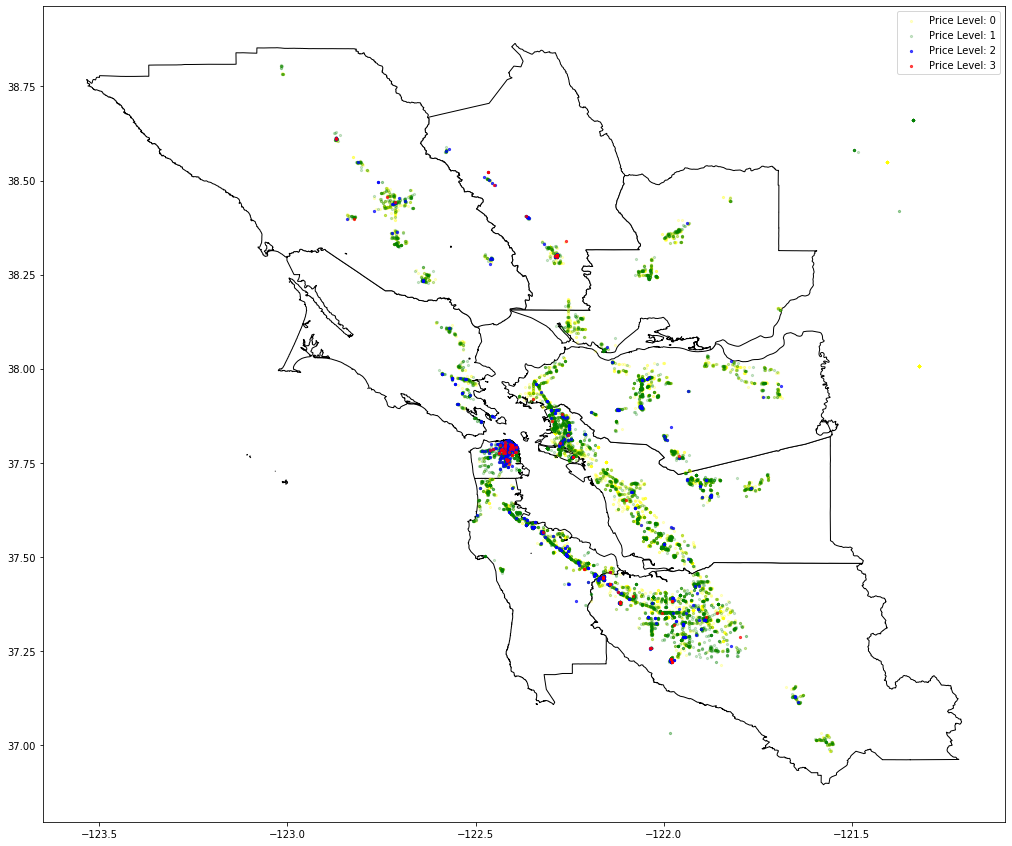

In [416]:
prices = np.sort([price_map[i] for i in unique_price])
colors = ['yellow','green','blue','red']

fig,ax = plt.subplots(figsize=(20,15))
bay_area_map.geometry.plot(ax=ax, color='white', edgecolor='black')
for i,j in zip(prices, colors):
    if j == 'yellow' or j == 'green':
        alpha = 0.2
    else:
        alpha = 0.7
    geo_business_info[geo_business_info.price == i].geometry.plot(ax=ax, 
                                                                  markersize=5, 
                                                                  color=j,
                                                                  alpha=alpha,
                                                                  label='Price Level: {}'.format(i))
plt.legend()
plt.show()